In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import spacy
from nltk.util import ngrams

%matplotlib inline

from nltk.corpus import stopwords

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

/home/jack/anaconda3/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/home/jack/anaconda3/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/home/jack/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


In [2]:
stop_words = stopwords.words('english')
stop_words.extend(['be','try','say','from','in','the', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [3]:
df = pd.read_csv('combined_csv.csv',sep='\t')
df.head()

,title,text,tag,date
0,IMA founder has at least 14 properties worth 5...,"Mohammed Mansoor Khan, the elusive managing di...","IMA fraud,",Jun 14 2019
1,Man who invested Rs 9L in IMA dies of heart at...,A 54-year-old man who had invested in the IMA ...,"IMA fraud,Chit fund,",Jun 14 2019
2,"BBMP, cops to meet over seized vehicles",Mayor Gangambike Mallikarjun on Thursday inspe...,"seized vehicles,BBMP,",Jun 14 2019
3,More women opt for MBA course at IIMB,The Indian Institute of Management Bangalore (...,"Bengaluru,Indian Institute of Management,IIMB,",Jun 13 2019
4,"Citizens suffer as fallen trees, branches lie ...",Trees and branches that were brought down by r...,"monsoon,BBMP,Rain damage,Benglauru,",Jun 13 2019


In [4]:
contraction = { 'isn\'t':'is not','aren\'t' : 'are not','wasn\'t':'was not','weren\'t':'were not',\
               'haven\'t':'have not', 'hasn\'t' :'has not','hadn\'t' :'had not','won\'t' :'will not',\
               'wouldn\'t':'would not' ,'don\'t':'do not' ,'doesn\'t':'does not','didn\'t':'did not',\
               'can\'t':'can not','couldn\'t':'could not','shouldn\'t':'should not','mightn\'t':'might not',\
               'mustn\'t':'must not'}

def exp(sent):
    new_sent=''
    words =sent.split()
    for i in words:
        if i in contraction:
            new_sent+=' '+contraction[i]
        else:
            new_sent+=' '+i
    return new_sent.strip()

def prep(sentence):
    sentence = exp(sentence)
    sentence = re.sub('[^a-zA-Z\']',' ', sentence)
    sentence = sentence.lower()
    sentence = sentence.split()
    sentence = ' '.join(sentence)
    return sentence

In [5]:
df['text'] =df['text'].apply(lambda x: prep(x))

In [6]:
df.head()

,title,text,tag,date
0,IMA founder has at least 14 properties worth 5...,mohammed mansoor khan the elusive managing dir...,"IMA fraud,",Jun 14 2019
1,Man who invested Rs 9L in IMA dies of heart at...,a year old man who had invested in the ima gro...,"IMA fraud,Chit fund,",Jun 14 2019
2,"BBMP, cops to meet over seized vehicles",mayor gangambike mallikarjun on thursday inspe...,"seized vehicles,BBMP,",Jun 14 2019
3,More women opt for MBA course at IIMB,the indian institute of management bangalore i...,"Bengaluru,Indian Institute of Management,IIMB,",Jun 13 2019
4,"Citizens suffer as fallen trees, branches lie ...",trees and branches that were brought down by r...,"monsoon,BBMP,Rain damage,Benglauru,",Jun 13 2019


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [10]:
data = df['text'].values.tolist()
data[0]

'mohammed mansoor khan the elusive managing director and ceo of the beleaguered ima group is said to own at least properties in various parts of bengaluru whose value runs into crores bbmp documents show that khan had been paying rs lakh in property tax every year the properties are located in upmarket areas like jayanagar benson road park road alexander street jayanagar th block st john s church road lady curzon road and hbr layout officials in the bbmp s revenue wing estimate the value of these properties at more than rs crore going by the current market value all the properties are registered in his name an official said on the condition of anonymity bbmp officials have not ruled out the possibility of other properties registered in the name of the ima group and are trying to identify them out of the properties the ima headquarters on lady curzon road accounted for the highest property tax payment at rs lakh per year'

In [13]:
data_words = list(sent_to_words(data))
data_words=remove_stopwords(data_words)

In [15]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [17]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [18]:
data_words_nostops = remove_stopwords(data_words)

In [24]:
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en',disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[0])

['mohammed_mansoor', 'khan', 'elusive', 'managing_director', 'ceo', 'beleaguered_ima', 'group', 'say', 'least', 'property', 'various', 'part', 'bengaluru', 'value', 'run', 'crore', 'bbmp', 'document', 'show', 'khan', 'pay', 'lakh', 'year', 'property', 'located_upmarket', 'area', 'jayanagar_benson', 'road', 'park', 'road', 'alexander_street', 'block', 'church', 'road', 'lady_curzon', 'road', 'official', 'bbmp', 'revenue', 'wing_estimate', 'value_propertie', 'go', 'current', 'market', 'value_propertie', 'register', 'name', 'official', 'say', 'condition_anonymity', 'bbmp', 'official', 'ruled_possibility', 'property', 'register', 'name', 'try', 'identify', 'property', 'be', 'headquarters_lady', 'curzon', 'road', 'accounted_high', 'payment', 'lakh', 'year']


In [23]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 3), (31, 1), (32, 1), (33, 1), (34, 1), (35, 4), (36, 2), (37, 1), (38, 5), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 2)]


In [25]:
lda_model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=28,random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda=lda_model[corpus]

[(4,
  '0.186*"passenger" + 0.183*"airport" + 0.074*"kia" + '
  '0.038*"international_airport" + 0.031*"bial" + 0.030*"terminal" + '
  '0.028*"kempegowda_international" + 0.026*"check" + 0.022*"security" + '
  '0.020*"limited_bial"'),
 (5,
  '0.049*"market" + 0.044*"violation" + 0.038*"festival" + 0.036*"club" + '
  '0.033*"manufacture" + 0.031*"annual" + 0.029*"roll" + 0.024*"production" + '
  '0.023*"registration" + 0.017*"co"'),
 (17,
  '0.276*"panchayat" + 0.052*"lakshmana" + 0.046*"campaign" + 0.026*"invest" + '
  '0.023*"temple" + 0.013*"consult" + 0.013*"pasha" + 0.012*"cm" + 0.011*"ram" '
  '+ 0.010*"ngo"'),
 (20,
  '0.042*"spokesperson" + 0.038*"reject" + 0.031*"manjunath" + 0.030*"cheat" + '
  '0.025*"clarify" + 0.024*"purpose" + 0.024*"vicinity" + 0.023*"chemical" + '
  '0.020*"substance" + 0.019*"proof"'),
 (0,
  '0.472*"lake" + 0.068*"decision" + 0.029*"solve" + 0.028*"future" + '
  '0.026*"rao" + 0.012*"rejuvenation" + 0.012*"fence" + 0.011*"showcase" + '
  '0.010*"lose" 

In [26]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.490178233968665

Coherence Score:  0.37571487595417646


In [27]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet
import os


os.environ.update({'MALLET_HOME':r'/home/jack/Downloads/mallet-2.0.8'})
mallet_path = '/home/jack/Downloads/mallet-2.0.8/bin/mallet'

In [28]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=13, id2word=id2word)

result = (ldamallet.show_topics(num_topics=3, num_words=10,formatted=False))
for each in result:
    print (each)

(5, [('police', 0.0814967763684632), ('arrest', 0.021912266655429606), ('accuse', 0.020437402553621843), ('man', 0.017192701529644767), ('case', 0.01373730563398087), ('woman', 0.013358054864944588), ('complaint', 0.01293666512157094), ('assault', 0.012136024609161014), ('victim', 0.01082971640470271), ('station', 0.00956554717458177)])
(2, [('road', 0.08828884842563396), ('work', 0.04556557267842075), ('bbmp', 0.040236265932406624), ('traffic', 0.024958919927166142), ('area', 0.012701514411333659), ('resident', 0.012124172847182129), ('project', 0.01074743527112848), ('vehicle', 0.010392148154727538), ('engineer', 0.010125682817426833), ('city', 0.009104232357774127)])
(7, [('official', 0.03212086586681902), ('bengaluru', 0.014790833492033263), ('airport', 0.013648193994794642), ('passenger', 0.012949914302037707), ('fire', 0.01193423474893671), ('officer', 0.011235955056179775), ('security', 0.010156795531009967), ('accord', 0.00971243572652828), ('senior', 0.009331555894115407), ('c

In [29]:
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('student', 0.04453257790368272),
   ('school', 0.023116147308781868),
   ('year', 0.016940509915014165),
   ('college', 0.015977337110481587),
   ('university', 0.013031161473087818),
   ('study', 0.008668555240793201),
   ('india', 0.00821529745042493),
   ('management', 0.0069121813031161475),
   ('education', 0.0069121813031161475),
   ('institute', 0.006685552407932011)]),
 (10,
  [('water', 0.051968581731956724),
   ('lake', 0.037445042730820534),
   ('resident', 0.024255298127747862),
   ('waste', 0.018475522402805908),
   ('bbmp', 0.018327323025243293),
   ('garbage', 0.017685125722471967),
   ('area', 0.014770537963740553),
   ('bengaluru', 0.011114953317196068),
   ('city', 0.009731759126611669),
   ('add', 0.009583559749049054)]),
 (1,
  [('police', 0.04840384702217004),
   ('year', 0.019867250643428005),
   ('house', 0.015081049352056713),
   ('driver', 0.013545852711428184),
   ('find', 0.01146882196234253),
   ('rush', 0.010565765114913984),
   ('hospital', 0.0104

In [30]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.49096666708755726


In [31]:
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/jack/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/jack/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/jack/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/home/jack/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.313464 -0.070003       1        1  8.761744
2     -0.151939 -0.217576       2        1  8.738458
1      0.269026 -0.081858       3        1  8.207961
9     -0.135031 -0.014846       4        1  8.196425
4     -0.062509 -0.019117       5        1  8.120689
10    -0.150585 -0.190559       6        1  8.069643
3     -0.201260 -0.091722       7        1  7.511836
11    -0.087982  0.233805       8        1  7.375932
8      0.218402  0.017069       9        1  7.330888
0     -0.086627  0.264461      10        1  7.266551
12    -0.001234  0.126629      11        1  7.060067
6      0.024359  0.065640      12        1  6.727185
7      0.051916 -0.021923      13        1  6.632621, topic_info=      Category         Freq        Term        Total  loglift  logprob
98     Default  3546.000000      police  3546.000000  30.0000  30.0000
38     Default  2107.000000        road  2107.000000  29.0000  29.0000
328    Default  1145.000000       water  1145.000000  28.0000  28.0000
3      Default  1861.000000        bbmp  1861.000000  27.0000  27.0000
247    Default   883.000000     student   883.000000  26.0000  26.0000
116    Default  1562.000000        work  1562.000000  25.0000  25.0000
682    Default   825.000000        lake   825.000000  24.0000  24.0000
452    Default  1096.000000  government  1096.000000  23.0000  23.0000
1293   Default   801.000000         bus   801.000000  22.0000  22.0000
63     Default   871.000000   complaint   871.000000  21.0000  21.0000
30     Default  1507.000000    official  1507.000000  20.0000  20.0000
75     Default   762.000000    hospital   762.000000  19.0000  19.0000
167    Default   778.000000     station   778.000000  18.0000  18.0000
2643   Default   582.000000       court   582.000000  17.0000  17.0000
171    Default   595.000000     traffic   595.000000  16.0000  16.0000
320    Default   529.000000        tree   529.000000  15.0000  15.0000
691    Default   903.000000     project   903.000000  14.0000  14.0000
405    Default   883.000000       state   883.000000  13.0000  13.0000
305    Default  1082.000000    resident  1082.000000  12.0000  12.0000
125    Default  1579.000000        city  1579.000000  11.0000  11.0000
1674   Default   627.000000      arrest   627.000000  10.0000  10.0000
701    Default   458.000000      school   458.000000   9.0000   9.0000
23     Default   591.000000        lakh   591.000000   8.0000   8.0000
1996   Default   558.000000      accuse   558.000000   7.0000   7.0000
2      Default   703.000000        area   703.000000   6.0000   6.0000
6      Default  1642.000000   bengaluru  1642.000000   5.0000   5.0000
249    Default   794.000000        time   794.000000   4.0000   4.0000
1198   Default   407.000000       waste   407.000000   3.0000   3.0000
48     Default  1840.000000        year  1840.000000   2.0000   2.0000
62     Default   504.000000     company   504.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
10494  Topic13    34.505039    malaysia    34.505039   2.7132  -6.2636
9      Topic13    34.505039      church    34.505039   2.7132  -6.2636
8057   Topic13    34.505039        doll    34.505039   2.7132  -6.2636
975    Topic13    34.505039     conceal    34.505039   2.7132  -6.2636
603    Topic13   247.286112     airport   280.696842   2.5864  -4.2941
4128   Topic13    64.409406       delhi    69.050269   2.6436  -5.6394
2417   Topic13    42.556215         tag    43.716430   2.6863  -6.0539
643    Topic13   234.634264   passenger   320.619294   2.4009  -4.3467
2916   Topic13    71.310414     library    81.971511   2.5738  -5.5377
971    Topic13   163.323850       check   227.376263   2.3823  -4.7090
162    Topic13   110.416124       seize   155.395940   2.3715  -5.1004
30     Topic13   581.984988    official  1507.715295   1.7613  -3.4382
638    Topic13   203.579729     office

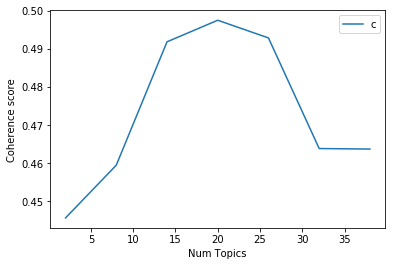

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
#first ask then run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# 
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
lda_model.print_topics(20,num_words=15)[:10]

[(0,
  '0.045*"student" + 0.023*"school" + 0.017*"year" + 0.016*"college" + 0.013*"university" + 0.009*"study" + 0.008*"india" + 0.007*"management" + 0.007*"education" + 0.007*"institute" + 0.007*"campus" + 0.007*"research" + 0.006*"add" + 0.006*"programme" + 0.006*"science"'),
 (1,
  '0.048*"police" + 0.020*"year" + 0.015*"house" + 0.014*"driver" + 0.011*"find" + 0.011*"rush" + 0.010*"hospital" + 0.010*"son" + 0.009*"pm" + 0.009*"fall" + 0.009*"wife" + 0.009*"car" + 0.008*"kill" + 0.008*"child" + 0.008*"home"'),
 (2,
  '0.088*"road" + 0.046*"work" + 0.040*"bbmp" + 0.025*"traffic" + 0.013*"area" + 0.012*"resident" + 0.011*"project" + 0.010*"vehicle" + 0.010*"engineer" + 0.009*"city" + 0.009*"complete" + 0.008*"stretch" + 0.008*"footpath" + 0.008*"flyover" + 0.007*"month"'),
 (3,
  '0.027*"city" + 0.026*"tree" + 0.024*"bbmp" + 0.019*"bengaluru" + 0.017*"park" + 0.013*"plant" + 0.010*"department" + 0.010*"set" + 0.009*"citizen" + 0.009*"official" + 0.008*"project" + 0.008*"add" + 0.008*"

In [35]:
x = lda_model.get_document_topics(corpus[0])
x

[(0, 0.04187475835680473),
 (1, 0.040491899228936826),
 (2, 0.13538267381372793),
 (3, 0.056771615011881285),
 (4, 0.05244477835839096),
 (5, 0.03939717383656594),
 (6, 0.03964469373337276),
 (7, 0.0830080634401657),
 (8, 0.3272931141605345),
 (9, 0.045199976255695884),
 (10, 0.04460344346829902),
 (11, 0.048692127710047564),
 (12, 0.04519568262557682)]

In [36]:
def tags(corp):
    x = lda_model.get_document_topics(corp)
    ans = []
    for i in x:
        if i[1] >=0.05:
            ans.append(i[0])
    return ans

In [37]:
df['cluster'] = [tags(corp) for corp in corpus]

In [38]:
df.head()

,title,text,tag,date,cluster
0,IMA founder has at least 14 properties worth 5...,mohammed mansoor khan the elusive managing dir...,"IMA fraud,",Jun 14 2019,"[2, 3, 4, 7, 8]"
1,Man who invested Rs 9L in IMA dies of heart at...,a year old man who had invested in the ima gro...,"IMA fraud,Chit fund,",Jun 14 2019,"[1, 2, 6, 8]"
2,"BBMP, cops to meet over seized vehicles",mayor gangambike mallikarjun on thursday inspe...,"seized vehicles,BBMP,",Jun 14 2019,"[2, 3, 4, 7, 9, 10]"
3,More women opt for MBA course at IIMB,the indian institute of management bangalore i...,"Bengaluru,Indian Institute of Management,IIMB,",Jun 13 2019,"[0, 4, 6, 9]"
4,"Citizens suffer as fallen trees, branches lie ...",trees and branches that were brought down by r...,"monsoon,BBMP,Rain damage,Benglauru,",Jun 13 2019,"[1, 2, 3, 10, 12]"


In [40]:
cluster_count =[]

In [41]:
month_count =np.zeros((11,13))
month_count

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [42]:
for i in df.index:
    if df['date'][i][-4:] == '2018':   
        if df['date'][i][:4].strip()=='Aug':
            for j in df['cluster'][i]:
                month_count[0][j]+=1
                
        elif df['date'][i][:4].strip()=='Sep':
            for j in df['cluster'][i]:
                month_count[1][j]+=1
                
        elif df['date'][i][:4].strip()=='Oct':
            for j in df['cluster'][i]:
                month_count[2][j]+=1
                
        elif df['date'][i][:4].strip()=='Nov':
            for j in df['cluster'][i]:
                month_count[3][j]+=1
                
        elif df['date'][i][:4].strip()=='Dec':
            for j in df['cluster'][i]:
                month_count[4][j]+=1
        
    else:
        if df['date'][i][:4].strip()=='Jun':
            for j in df['cluster'][i]:
                month_count[10][j]+=1
                
        elif df['date'][i][:4].strip()=='May':
            for j in df['cluster'][i]:
                month_count[9][j]+=1
                
        elif df['date'][i][:4].strip()=='Apr':
            for j in df['cluster'][i]:
                month_count[8][j]+=1
        
        elif df['date'][i][:4].strip()=='Mar':
            for j in df['cluster'][i]:
                month_count[7][j]+=1
        
        elif df['date'][i][:4].strip()=='Feb':
            for j in df['cluster'][i]:
                month_count[6][j]+=1
        
        elif df['date'][i][:4].strip()=='Jan':
            for j in df['cluster'][i]:
                month_count[5][j]+=1


In [43]:
month_count

array([[ 22.,  14.,  42.,  32.,  38.,   4.,  14.,  26.,  10.,  40.,  40.,
         26.,  22.],
       [ 40.,  34.,  90.,  78.,  94.,  14.,  32.,  54.,  56.,  84.,  88.,
         44.,  78.],
       [ 74.,  48.,  82.,  74.,  90.,  32.,  68.,  46.,  52.,  74.,  70.,
         94.,  82.],
       [ 24.,  26.,  64.,  68.,  64.,  16.,  42.,  48.,  28.,  42.,  54.,
         60.,  60.],
       [ 72.,  58.,  84.,  64.,  86.,  34.,  58.,  56.,  56.,  82.,  58.,
         64.,  90.],
       [ 86.,  94.,  98.,  98., 120.,  92.,  68.,  90.,  86.,  90.,  70.,
         80., 104.],
       [ 66.,  60.,  52.,  44.,  50.,  58.,  48.,  50.,  54.,  60.,  32.,
         58.,  70.],
       [140., 210., 164., 146., 178., 228., 140., 166., 206., 152., 116.,
        122., 208.],
       [ 68., 136.,  68.,  52.,  78., 124.,  94., 104., 108.,  74.,  56.,
         74., 114.],
       [ 48., 120.,  76.,  48.,  74., 114.,  56.,  76., 106.,  60.,  46.,
         54.,  88.],
       [ 42.,  90.,  78.,  62.,  86.,  80.,  64., 

In [44]:
cluster_tags = {'0':'crime_money','1':'crime_kidnaps_arrests_assaults','2':'infra_government_specific','3':'infra_maintainance','4':'crime_murder_suicides','5':'infra_nagarpalika','6':'lifestyle_studentlife','7':'infra_developments','8':'lifestyle_basiceminities','9':'infra_travel','10':'lifestyle_medical','11':'lifestyle_commonpeople','12':'infra_tourists'}

In [45]:
col =[]
for i in cluster_tags.keys():
    col.append(cluster_tags[i])

In [46]:
col

['crime_money',
 'crime_kidnaps_arrests_assaults',
 'infra_government_specific',
 'infra_maintainance',
 'crime_murder_suicides',
 'infra_nagarpalika',
 'lifestyle_studentlife',
 'infra_developments',
 'lifestyle_basiceminities',
 'infra_travel',
 'lifestyle_medical',
 'lifestyle_commonpeople',
 'infra_tourists']

In [47]:
db = pd.DataFrame(month_count, columns=col)

In [48]:
db.head()

,crime_money,crime_kidnaps_arrests_assaults,infra_government_specific,infra_maintainance,crime_murder_suicides,infra_nagarpalika,lifestyle_studentlife,infra_developments,lifestyle_basiceminities,infra_travel,lifestyle_medical,lifestyle_commonpeople,infra_tourists
0,22.0,14.0,42.0,32.0,38.0,4.0,14.0,26.0,10.0,40.0,40.0,26.0,22.0
1,40.0,34.0,90.0,78.0,94.0,14.0,32.0,54.0,56.0,84.0,88.0,44.0,78.0
2,74.0,48.0,82.0,74.0,90.0,32.0,68.0,46.0,52.0,74.0,70.0,94.0,82.0
3,24.0,26.0,64.0,68.0,64.0,16.0,42.0,48.0,28.0,42.0,54.0,60.0,60.0
4,72.0,58.0,84.0,64.0,86.0,34.0,58.0,56.0,56.0,82.0,58.0,64.0,90.0


In [49]:
db.to_csv("monthsd.csv",index=False)